In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [ ]:
train_dir = "/content/drive/MyDrive/Sem6/AI and ML Workshop/Week-5/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/Sem6/AI and ML Workshop/Week-5/FruitinAmazon/test"

In [ ]:
class_names = os.listdir(train_dir)
print(f"Classes: {class_names}")

Classes: ['guarana', 'cupuacu', 'acai', 'graviola', 'tucuma', 'pupunha']


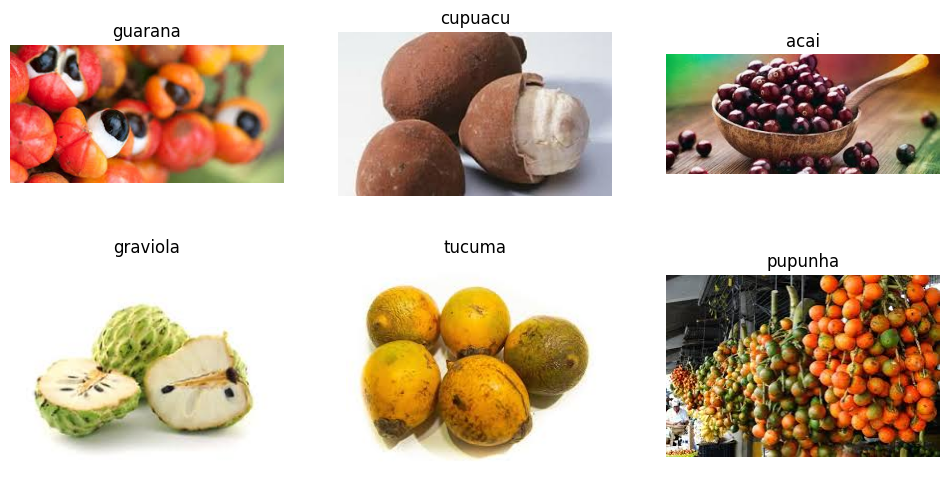

In [ ]:
def visualize_images(train_dir, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_dir, class_names)

In [ ]:
damagedImages = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)  # Try opening the image
        except (IOError, SyntaxError):
            damagedImages.append(img_path)
            os.remove(img_path)
            print(f"Damaged image removed: {img_path}")

if not damagedImages:
    print("No Damaged Images Found.")

No Damaged Images Found.


In [ ]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [ ]:
rescale = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [ ]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2,2), strides=2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.0845 - loss: 1.8990

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 828ms/step - accuracy: 0.0877 - loss: 1.9148 - val_accuracy: 0.8333 - val_loss: 1.2248
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.2426 - loss: 1.7563 - val_accuracy: 0.3333 - val_loss: 1.6533
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.2630 - loss: 1.6357 - val_accuracy: 0.7778 - val_loss: 1.3306
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.6784 - loss: 1.3569 - val_accuracy: 0.7222 - val_loss: 1.1300
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.6949 - loss: 1.0867 - val_accuracy: 0.8333 - val_loss: 0.9343
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 712ms/step - accuracy: 0.7656 - loss: 0.8487 - val_accuracy: 0.7222 - val_loss: 0.8946
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.8346 - loss: 0.5854 - val_accuracy: 0.8333 - val_loss: 0.7618
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9404 - loss: 0.4178

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - accuracy: 0.9379 - loss: 0.4175 - val_accuracy: 0.8889 - val_loss: 0.4303
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 0.9488 - loss: 0.2914 - val_accuracy: 0.7778 - val_loss: 0.6497
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.9518 - loss: 0.1764 - val_accuracy: 0.6111 - val_loss: 0.6748
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9699 - loss: 0.1489

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - accuracy: 0.9705 - loss: 0.1446 - val_accuracy: 0.9444 - val_loss: 0.2965
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 774ms/step - accuracy: 1.0000 - loss: 0.0773 - val_accuracy: 0.8333 - val_loss: 0.5580
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 438ms/step - accuracy: 0.9891 - loss: 0.1062 - val_accuracy: 0.8333 - val_loss: 0.3475
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 1.0000 - loss: 0.0372 - val_accuracy: 0.8333 - val_loss: 0.3173
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.9931 - loss: 0.0524 - val_accuracy: 0.8889 - val_loss: 0.3237
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.9813 - loss: 0.0441 - val_accuracy: 0.9444 - val_loss: 0.2476
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 733ms/step - accuracy: 1.0000 - loss: 0.0410 - val_accuracy: 0.8889 - val_loss: 0.2885
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 514ms/step - accuracy: 1.0000 - loss: 0.0348 - val_accuracy: 0.8333 - val_lo

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7333 - loss: 0.9735
Test Accuracy: 73.33%


In [ ]:
model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = loaded_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
              precision    recall  f1-score   support

     guarana       0.71      1.00      0.83         5
     cupuacu       0.75      0.60      0.67         5
        acai       0.71      1.00      0.83         5
    graviola       0.62      1.00      0.77         5
      tucuma       1.00      0.40      0.57         5
     pupunha       1.00      0.40      0.57         5

    accuracy                           0.73        30
   macro avg       0.80      0.73      0.71        30
weighted avg       0.80      0.73      0.71        30



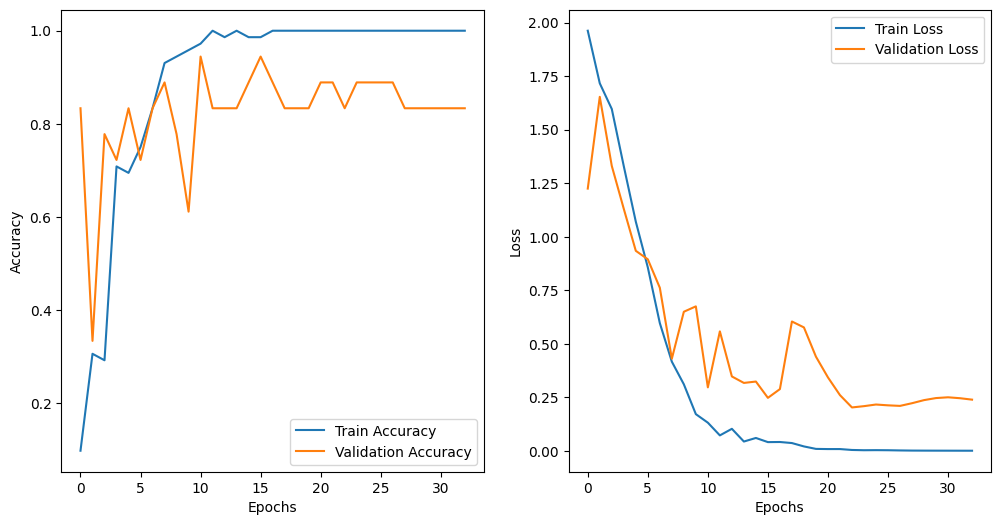

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()